In [95]:
import torchvision
import torch.nn as nn
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms,models,datasets
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from torch import optim
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import cv2, glob, numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob
import os
from torchsummary import summary
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
%matplotlib inline
from sklearn.exceptions import UndefinedMetricWarning
import warnings
warnings.filterwarnings(action='ignore', category=UndefinedMetricWarning)
import os
from collections.abc import Iterable

In [96]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
FOLD = 1

## Loading data 

In [97]:
paths_patients_malignant = glob("BreaKHis_v1/histology_slides/breast/malignant/*/*/*")
paths_patients_benign = glob("BreaKHis_v1/histology_slides/breast/benign/*/*/*")


In [98]:
from torch.utils.data import DataLoader, Dataset
class imagesXNN(Dataset):
  def __init__(self, paths):
    self.fpaths = paths

  def __len__(self): return len(self.fpaths)

  def __getitem__(self, ix):
    f = self.fpaths[ix]
    res = torch.tensor(int("malignant" in f)).type(torch.LongTensor)
    im = cv2.imread(f)[:,:,::-1]
    return transforms.Compose([transforms.RandomCrop(440), 
                               transforms.RandomHorizontalFlip(), 
                               transforms.RandomVerticalFlip()])(torch.tensor(im/255).permute(2,0,1).float()), res



from torch.utils.data import DataLoader, Dataset
class imagesTestXNN(Dataset):
  def __init__(self, paths):
    self.fpaths = paths

  def __len__(self): return len(self.fpaths)

  def __getitem__(self, ix):
    f = self.fpaths[ix]
    res = torch.tensor(int("malignant" in f)).type(torch.LongTensor)
    im = cv2.imread(f)[:,:,::-1]
    return transforms.Compose([transforms.CenterCrop(440)])(torch.tensor(im/255).permute(2,0,1).float()), res



In [99]:
from sklearn.model_selection import train_test_split
from collections import defaultdict
train_mali, test_mali = train_test_split(paths_patients_malignant, train_size=0.8)
train_ben, test_ben = train_test_split(paths_patients_benign, train_size=0.8)

In [100]:
mali_train_40 = [i for j in train_mali for i in glob(f"{j}/40X/*.png")]
mali_train_100 = [i for j in train_mali for i in glob(f"{j}/100X/*.png")]
mali_train_200 = [i for j in train_mali for i in glob(f"{j}/200X/*.png")]
mali_train_400 = [i for j in train_mali for i in glob(f"{j}/400X/*.png")]
ben_train_40 = [i for j in train_ben for i in glob(f"{j}/40X/*.png")]
ben_train_100 = [i for j in train_ben for i in glob(f"{j}/100X/*.png")]
ben_train_200 = [i for j in train_ben for i in glob(f"{j}/200X/*.png")]
ben_train_400 = [i for j in train_ben for i in glob(f"{j}/400X/*.png")]

In [101]:
mali_test_40 = [i for j in test_mali for i in glob(f"{j}/40X/*.png")]
mali_test_100 = [i for j in test_mali for i in glob(f"{j}/100X/*.png")]
mali_test_200 = [i for j in test_mali for i in glob(f"{j}/200X/*.png")]
mali_test_400 = [i for j in test_mali for i in glob(f"{j}/400X/*.png")]
ben_test_40 = [i for j in test_ben for i in glob(f"{j}/40X/*.png")]
ben_test_100 = [i for j in test_ben for i in glob(f"{j}/100X/*.png")]
ben_test_200 = [i for j in test_ben for i in glob(f"{j}/200X/*.png")]
ben_test_400 = [i for j in test_ben for i in glob(f"{j}/400X/*.png")]

In [102]:
len(mali_train_40)+len(mali_train_100)+len(mali_train_200)+len(mali_train_400)+\
   len(ben_train_40)+len(ben_train_100)+len(ben_train_200)+len(ben_train_400) +\
len(mali_test_40)+len(mali_test_100)+len(mali_test_200)+len(mali_test_400)+\
   len(ben_test_40)+len(ben_test_100)+len(ben_test_200)+len(ben_test_400)

7909

In [103]:
train_40 = imagesXNN(mali_train_40 + ben_train_40)
test_40 = imagesTestXNN(mali_test_40+ ben_test_40)

In [104]:
trn_dl = DataLoader(train_40, batch_size=2, shuffle=True, drop_last = True, num_workers = 0)
test_dl = DataLoader(test_40, batch_size=2, shuffle=False, num_workers = 0)

## Basic pretrained model

In [454]:
model = torchvision.models.efficientnet_v2_s(weights=torchvision.models.EfficientNet_V2_S_Weights.DEFAULT)
#model = torchvision.models.efficientnet_v2_s()
modelname="efficientnet_v2_s"
for param in model.features.parameters():
    param.requires_grad = True

In [455]:
model.classifier = nn.Sequential( nn.Linear(1280, 512),nn.Dropout(0.2, inplace=True),nn.ReLU(), nn.Linear(512, 2))

In [456]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr= 1e-6)

In [457]:
model = model.to(device)

In [458]:
summary(model, ( 3, 460,460))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 24, 230, 230]             648
       BatchNorm2d-2         [-1, 24, 230, 230]              48
              SiLU-3         [-1, 24, 230, 230]               0
            Conv2d-4         [-1, 24, 230, 230]           5,184
       BatchNorm2d-5         [-1, 24, 230, 230]              48
              SiLU-6         [-1, 24, 230, 230]               0
   StochasticDepth-7         [-1, 24, 230, 230]               0
       FusedMBConv-8         [-1, 24, 230, 230]               0
            Conv2d-9         [-1, 24, 230, 230]           5,184
      BatchNorm2d-10         [-1, 24, 230, 230]              48
             SiLU-11         [-1, 24, 230, 230]               0
  StochasticDepth-12         [-1, 24, 230, 230]               0
      FusedMBConv-13         [-1, 24, 230, 230]               0
           Conv2d-14         [-1, 96, 1

In [459]:
tolerance = 0.83
def train(model, num_epochs, train_dl, valid_dl):
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs
    for epoch in range(num_epochs):
        model.train()
        for x_batch, y_batch in train_dl:
            x_batch = x_batch.to(device) 
            y_batch = y_batch.to(device).squeeze()
            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_hist_train[epoch] += loss.item()*y_batch.size(0)
            is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.sum().cpu()

        loss_hist_train[epoch] /= len(train_dl.dataset)
        accuracy_hist_train[epoch] /= len(train_dl.dataset)
        
        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                x_batch = x_batch.to(device) 
                y_batch = y_batch.to(device).squeeze() 
                pred = model(x_batch)
                loss = loss_fn(pred, y_batch)
                loss_hist_valid[epoch] += loss.item()*y_batch.size(0) 
                is_correct = (torch.argmax(pred, dim=1) == y_batch).float() 
                accuracy_hist_valid[epoch] += is_correct.sum().cpu()
        loss_hist_valid[epoch] /= len(valid_dl.dataset)
        accuracy_hist_valid[epoch] /= len(valid_dl.dataset)
        if epoch == 0:
            bestAccVal = accuracy_hist_valid[epoch]
        else:
            if accuracy_hist_valid[epoch] > max(bestAccVal, tolerance):
                bestAccVal = accuracy_hist_valid[epoch]
                torch.save(model.state_dict(), f'{modelname}_val{bestAccVal}_ep{epoch}.pt')

        print(f'Epoch {epoch+1} accuracy: {accuracy_hist_train[epoch]:.4f} val_accuracy: {accuracy_hist_valid[epoch]:.4f}')
    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid

torch.manual_seed(42)
num_epochs = 40
hist = train(model, num_epochs, trn_dl, test_dl)

Epoch 1 accuracy: 0.6077 val_accuracy: 0.6776
Epoch 2 accuracy: 0.6667 val_accuracy: 0.7371
Epoch 3 accuracy: 0.6858 val_accuracy: 0.7199
Epoch 4 accuracy: 0.6836 val_accuracy: 0.7402
Epoch 5 accuracy: 0.6873 val_accuracy: 0.7402
Epoch 6 accuracy: 0.6917 val_accuracy: 0.7418
Epoch 7 accuracy: 0.6940 val_accuracy: 0.7465
Epoch 8 accuracy: 0.6940 val_accuracy: 0.7512
Epoch 9 accuracy: 0.7013 val_accuracy: 0.7809
Epoch 10 accuracy: 0.7183 val_accuracy: 0.7919
Epoch 11 accuracy: 0.7168 val_accuracy: 0.7950
Epoch 12 accuracy: 0.7183 val_accuracy: 0.8185
Epoch 13 accuracy: 0.7345 val_accuracy: 0.8435
Epoch 14 accuracy: 0.7441 val_accuracy: 0.8419
Epoch 15 accuracy: 0.7625 val_accuracy: 0.8513
Epoch 16 accuracy: 0.7655 val_accuracy: 0.8592
Epoch 17 accuracy: 0.7876 val_accuracy: 0.8560
Epoch 18 accuracy: 0.7861 val_accuracy: 0.8545
Epoch 19 accuracy: 0.8112 val_accuracy: 0.8576
Epoch 20 accuracy: 0.8083 val_accuracy: 0.8670
Epoch 21 accuracy: 0.8267 val_accuracy: 0.8638
Epoch 22 accuracy: 0.8

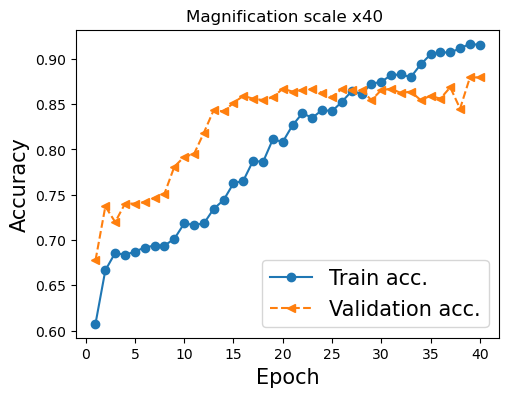

In [468]:
import matplotlib.pyplot as plt


x_arr = np.arange(len(hist[0])) + 1

fig = plt.figure(figsize=(12, 4))

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr[:40], hist[2], '-o', label='Train acc.')
ax.plot(x_arr[:40], hist[3], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_title("Magnification scale x40 ")
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)
#plt.savefig('figures/14_13.png')
plt.show()

In [68]:
from glob import glob
from collections import defaultdict
model = torchvision.models.efficientnet_v2_s()
modelname="efficientnet_v2_s"
model.classifier = nn.Sequential( nn.Linear(1280, 512),nn.Dropout(0.2, inplace=True),nn.ReLU(), nn.Linear(512, 2))
model.load_state_dict(torch.load('efficientnet_v2_s_val0.8616071343421936_ep7.pt'))
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr= 1e-5)

In [188]:
loss_hist_valid = [0] * 1
accuracy_hist_valid = [0] * 1
valid_dl = test_dl
model = model.to(device)
model.eval()
with torch.no_grad():
    for x_batch, y_batch in valid_dl:
        x_batch = x_batch.to(device) 
        y_batch = y_batch.to(device).squeeze() 
        pred = model(x_batch)
        loss = loss_fn(pred, y_batch)
        loss_hist_valid[0] += loss.item()*y_batch.size(0) 
        is_correct = (torch.argmax(pred, dim=1) == y_batch).float() 
        accuracy_hist_valid[0] += is_correct.sum().cpu()
loss_hist_valid[0] /= len(valid_dl.dataset)
accuracy_hist_valid[0] /= len(valid_dl.dataset)


print(f'Epoch {0+1} test accuracy: {accuracy_hist_valid[0]:.4f}')

Epoch 1 test accuracy: 0.8616


### Patient wise accuracies

In [14]:
patients_benign_ids = [x.split("\\")[-1] for x in glob("BreaKHis_v1/histology_slides/breast/benign/SOB/*/*")]
patients_benign_paths_by_id_x40 = {x:glob(f"BreaKHis_v1/histology_slides/breast/benign/SOB/*/{x}/40X/*") for x in patients_benign_ids}
patients_benign_paths_by_id_x100 = {x:glob(f"BreaKHis_v1/histology_slides/breast/benign/SOB/*/{x}/100X/*") for x in patients_benign_ids}
patients_benign_paths_by_id_x200 = {x:glob(f"BreaKHis_v1/histology_slides/breast/benign/SOB/*/{x}/200X/*") for x in patients_benign_ids}
patients_benign_paths_by_id_x400 = {x:glob(f"BreaKHis_v1/histology_slides/breast/benign/SOB/*/{x}/400X/*") for x in patients_benign_ids}
print(patients_benign_paths_by_id_x40.keys())

dict_keys(['SOB_B_A_14-22549AB', 'SOB_B_A_14-22549CD', 'SOB_B_A_14-22549G', 'SOB_B_A_14-29960CD', 'SOB_B_F_14-14134', 'SOB_B_F_14-14134E', 'SOB_B_F_14-21998CD', 'SOB_B_F_14-21998EF', 'SOB_B_F_14-23060AB', 'SOB_B_F_14-23060CD', 'SOB_B_F_14-23222AB', 'SOB_B_F_14-25197', 'SOB_B_F_14-29960AB', 'SOB_B_F_14-9133', 'SOB_B_PT_14-21998AB', 'SOB_B_PT_14-22704', 'SOB_B_PT_14-29315EF', 'SOB_B_TA_14-13200', 'SOB_B_TA_14-15275', 'SOB_B_TA_14-16184', 'SOB_B_TA_14-16184CD', 'SOB_B_TA_14-19854C', 'SOB_B_TA_14-21978AB', 'SOB_B_TA_14-3411F'])


In [15]:
patients_malignant_ids = [x.split("\\")[-1] for x in glob("BreaKHis_v1/histology_slides/breast/malignant/SOB/*/*")]
patients_malignant_paths_by_id_x40 = {x:glob(f"BreaKHis_v1/histology_slides/breast/malignant/SOB/*/{x}/40X/*") for x in patients_malignant_ids}
patients_malignant_paths_by_id_x100 = {x:glob(f"BreaKHis_v1/histology_slides/breast/malignant/SOB/*/{x}/100X/*") for x in patients_malignant_ids}
patients_malignant_paths_by_id_x200 = {x:glob(f"BreaKHis_v1/histology_slides/breast/malignant/SOB/*/{x}/200X/*") for x in patients_malignant_ids}
patients_malignant_paths_by_id_x400 = {x:glob(f"BreaKHis_v1/histology_slides/breast/malignant/SOB/*/{x}/400X/*") for x in patients_malignant_ids}
print(patients_malignant_paths_by_id_x40.keys())

dict_keys(['SOB_M_DC_14-10926', 'SOB_M_DC_14-11031', 'SOB_M_DC_14-11520', 'SOB_M_DC_14-11951', 'SOB_M_DC_14-12312', 'SOB_M_DC_14-13412', 'SOB_M_DC_14-13993', 'SOB_M_DC_14-14015', 'SOB_M_DC_14-14926', 'SOB_M_DC_14-14946', 'SOB_M_DC_14-15572', 'SOB_M_DC_14-15696', 'SOB_M_DC_14-15792', 'SOB_M_DC_14-16188', 'SOB_M_DC_14-16336', 'SOB_M_DC_14-16448', 'SOB_M_DC_14-16601', 'SOB_M_DC_14-16716', 'SOB_M_DC_14-16875', 'SOB_M_DC_14-17614', 'SOB_M_DC_14-17901', 'SOB_M_DC_14-17915', 'SOB_M_DC_14-18650', 'SOB_M_DC_14-20629', 'SOB_M_DC_14-20636', 'SOB_M_DC_14-2523', 'SOB_M_DC_14-2773', 'SOB_M_DC_14-2980', 'SOB_M_DC_14-2985', 'SOB_M_DC_14-3909', 'SOB_M_DC_14-4364', 'SOB_M_DC_14-4372', 'SOB_M_DC_14-5287', 'SOB_M_DC_14-5694', 'SOB_M_DC_14-5695', 'SOB_M_DC_14-6241', 'SOB_M_DC_14-8168', 'SOB_M_DC_14-9461', 'SOB_M_LC_14-12204', 'SOB_M_LC_14-13412', 'SOB_M_LC_14-15570', 'SOB_M_LC_14-15570C', 'SOB_M_LC_14-16196', 'SOB_M_MC_14-10147', 'SOB_M_MC_14-12773', 'SOB_M_MC_14-13413', 'SOB_M_MC_14-13418DE', 'SOB_M_MC_14

In [165]:
len(glob(f"BreaKHis_v1/histology_slides/breast/malignant/SOB/*/SOB_M_PC_15-190EF/40X/*"))

19

In [16]:
glob(f"BreaKHis_v1/histology_slides/breast/malignant/SOB/*/*/400X/*")

['BreaKHis_v1/histology_slides/breast/malignant/SOB\\ductal_carcinoma\\SOB_M_DC_14-10926\\400X\\SOB_M_DC-14-10926-400-001.png',
 'BreaKHis_v1/histology_slides/breast/malignant/SOB\\ductal_carcinoma\\SOB_M_DC_14-10926\\400X\\SOB_M_DC-14-10926-400-002.png',
 'BreaKHis_v1/histology_slides/breast/malignant/SOB\\ductal_carcinoma\\SOB_M_DC_14-10926\\400X\\SOB_M_DC-14-10926-400-003.png',
 'BreaKHis_v1/histology_slides/breast/malignant/SOB\\ductal_carcinoma\\SOB_M_DC_14-10926\\400X\\SOB_M_DC-14-10926-400-004.png',
 'BreaKHis_v1/histology_slides/breast/malignant/SOB\\ductal_carcinoma\\SOB_M_DC_14-10926\\400X\\SOB_M_DC-14-10926-400-005.png',
 'BreaKHis_v1/histology_slides/breast/malignant/SOB\\ductal_carcinoma\\SOB_M_DC_14-10926\\400X\\SOB_M_DC-14-10926-400-006.png',
 'BreaKHis_v1/histology_slides/breast/malignant/SOB\\ductal_carcinoma\\SOB_M_DC_14-10926\\400X\\SOB_M_DC-14-10926-400-007.png',
 'BreaKHis_v1/histology_slides/breast/malignant/SOB\\ductal_carcinoma\\SOB_M_DC_14-10926\\400X\\SOB_M_DC

In [17]:
sums = 0
for i in patients_malignant_paths_by_id_x400:
    sums+=len(patients_malignant_paths_by_id_x400[i])
print(sums)

1232


In [18]:
print(len(patients_malignant_paths_by_id_x400["SOB_M_MC_14-19979C"]))

15


In [19]:
m=40
exec(f"""patients_paths_by_id_x{m} = dict()\n
patients_paths_by_id_x{m}.update(patients_malignant_paths_by_id_x{m})\n
patients_paths_by_id_x{m}.update(patients_benign_paths_by_id_x{m})\n""")

In [21]:
for m in [40,100,200,400]:
    exec(f"patients_paths_by_id_x{m} = dict()", globals())
    exec(f"patients_paths_by_id_x{m}.update(patients_malignant_paths_by_id_x{m})", globals())
    exec(f"patients_paths_by_id_x{m}.update(patients_benign_paths_by_id_x{m})", globals())


In [22]:
def accuracy_by_patient_id(model, patient_id, magnification_factor, verbose=0):
    exec(f"paths = patients_paths_by_id_x{magnification_factor}['{patient_id}']", globals())
    dataset = imagesTestXNN(paths)
    dataloader = DataLoader(dataset, batch_size=16, shuffle=True, drop_last = False, num_workers = 0)
    model = model.to(device)
    model.eval()
    correct_count = 0
    correctly_predicted = False
    accuracy=0
    with torch.no_grad():
        for x_batch, y_batch in dataloader:
            x_batch = x_batch.to(device) 
            y_batch = y_batch.to(device).squeeze()
            pred = model(x_batch)
            is_correct = (torch.argmax(pred, dim=1) == y_batch).float() 
            accuracy +=  is_correct.sum().cpu()
    accuracy /= len(dataloader.dataset)
    if verbose>0:
        print("patient_id:",patient_id)
        print("Accuracy:", accuracy.cpu().item())
        print()
    if accuracy>0.5:
        correctly_predicted = True
    return accuracy, correctly_predicted
    
    

In [23]:
def patientwise_accuracy(model,patient_ids, magnification, verbose=0):
    accuracy = 0
    for patient_id in patient_ids:
        accuracy+=accuracy_by_patient_id(model,patient_id, magnification, verbose)[0]
    return accuracy/len(patient_ids)

In [471]:
patientwise_accuracy(model,patients_paths_by_id_x40.keys(),40, 1)

patient_id: SOB_M_DC_14-10926
Accuracy: 1.0

patient_id: SOB_M_DC_14-11031
Accuracy: 1.0

patient_id: SOB_M_DC_14-11520
Accuracy: 1.0

patient_id: SOB_M_DC_14-11951
Accuracy: 1.0

patient_id: SOB_M_DC_14-12312
Accuracy: 1.0

patient_id: SOB_M_DC_14-13412
Accuracy: 1.0

patient_id: SOB_M_DC_14-13993
Accuracy: 1.0

patient_id: SOB_M_DC_14-14015
Accuracy: 1.0

patient_id: SOB_M_DC_14-14926
Accuracy: 0.949999988079071

patient_id: SOB_M_DC_14-14946
Accuracy: 0.9354838728904724

patient_id: SOB_M_DC_14-15572
Accuracy: 1.0

patient_id: SOB_M_DC_14-15696
Accuracy: 1.0

patient_id: SOB_M_DC_14-15792
Accuracy: 1.0

patient_id: SOB_M_DC_14-16188
Accuracy: 1.0

patient_id: SOB_M_DC_14-16336
Accuracy: 1.0

patient_id: SOB_M_DC_14-16448
Accuracy: 0.9090909361839294

patient_id: SOB_M_DC_14-16601
Accuracy: 1.0

patient_id: SOB_M_DC_14-16716
Accuracy: 1.0

patient_id: SOB_M_DC_14-16875
Accuracy: 1.0

patient_id: SOB_M_DC_14-17614
Accuracy: 1.0

patient_id: SOB_M_DC_14-17901
Accuracy: 1.0

patient_id:

tensor(0.9509)

### Medium sized pretrained EffNetV2 with scheduler

In [37]:
model_m = torchvision.models.efficientnet_v2_m(weights=torchvision.models.EfficientNet_V2_M_Weights.DEFAULT)
#model = torchvision.models.efficientnet_v2_s()
modelname="efficientnet_v2_m"
for param in model_m.features.parameters():
    param.requires_grad = True

In [38]:
model_m.classifier = nn.Sequential( nn.Linear(1280, 512),nn.Dropout(0.3, inplace=True),nn.ReLU(), nn.Linear(512, 2))

In [39]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_m.parameters(), lr= 1e-4)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10,20,40,60], gamma=0.3)

In [40]:
model_m = model_m.to(device)

In [41]:
summary(model_m, ( 3, 460,460))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 24, 230, 230]             648
       BatchNorm2d-2         [-1, 24, 230, 230]              48
              SiLU-3         [-1, 24, 230, 230]               0
            Conv2d-4         [-1, 24, 230, 230]           5,184
       BatchNorm2d-5         [-1, 24, 230, 230]              48
              SiLU-6         [-1, 24, 230, 230]               0
   StochasticDepth-7         [-1, 24, 230, 230]               0
       FusedMBConv-8         [-1, 24, 230, 230]               0
            Conv2d-9         [-1, 24, 230, 230]           5,184
      BatchNorm2d-10         [-1, 24, 230, 230]              48
             SiLU-11         [-1, 24, 230, 230]               0
  StochasticDepth-12         [-1, 24, 230, 230]               0
      FusedMBConv-13         [-1, 24, 230, 230]               0
           Conv2d-14         [-1, 24, 2

In [21]:
from tqdm import tqdm

In [4]:
tolerance = 0.83
def train(model, num_epochs, train_dl, valid_dl):
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs
    for epoch in range(num_epochs):
        model.train()
        for x_batch, y_batch in tqdm(train_dl):
            x_batch = x_batch.to(device) 
            y_batch = y_batch.to(device).squeeze()
            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            loss_hist_train[epoch] += loss.item()*y_batch.size(0)
            is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.sum().cpu()
        scheduler.step()
        loss_hist_train[epoch] /= len(train_dl.dataset)
        accuracy_hist_train[epoch] /= len(train_dl.dataset)
        
        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                x_batch = x_batch.to(device) 
                y_batch = y_batch.to(device).squeeze() 
                pred = model(x_batch)
                loss = loss_fn(pred, y_batch)
                loss_hist_valid[epoch] += loss.item()*y_batch.size(0) 
                is_correct = (torch.argmax(pred, dim=1) == y_batch).float() 
                accuracy_hist_valid[epoch] += is_correct.sum().cpu()
        loss_hist_valid[epoch] /= len(valid_dl.dataset)
        accuracy_hist_valid[epoch] /= len(valid_dl.dataset)
        if epoch == 0:
            bestAccVal = accuracy_hist_valid[epoch]
        else:
            if accuracy_hist_valid[epoch] > max(bestAccVal, tolerance):
                bestAccVal = accuracy_hist_valid[epoch]
                torch.save(model.state_dict(), f'{modelname}_val{bestAccVal}_ep{epoch}.pt')

        print(f'Epoch {epoch+1} accuracy: {accuracy_hist_train[epoch]:.4f} val_accuracy: {accuracy_hist_valid[epoch]:.4f}')
    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid

torch.manual_seed(42)
num_epochs = 80
hist = train(model_m, num_epochs, trn_dl, test_dl)

NameError: name 'model_m' is not defined

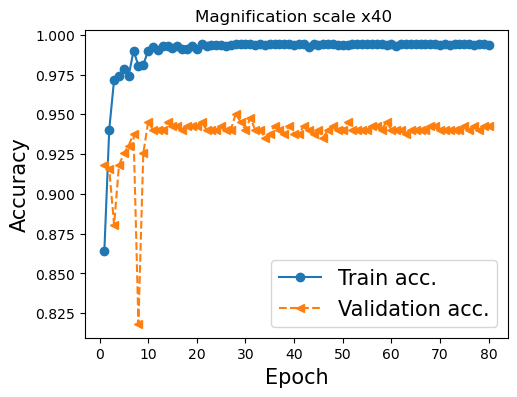

In [44]:
import matplotlib.pyplot as plt


x_arr = np.arange(len(hist[0])) + 1

fig = plt.figure(figsize=(12, 4))

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist[2], '-o', label='Train acc.')
ax.plot(x_arr, hist[3], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_title("Magnification scale x40 ")
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)
#plt.savefig('figures/14_13.png')
plt.show()

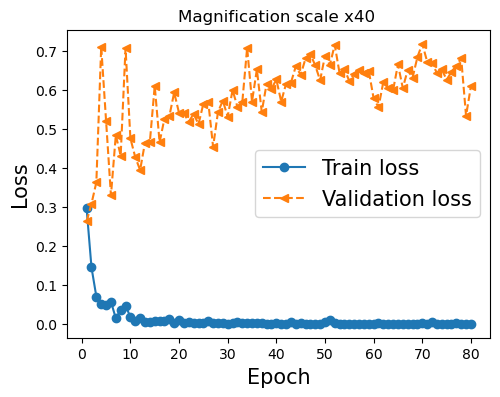

In [45]:
x_arr = np.arange(len(hist[0])) + 1

fig = plt.figure(figsize=(12, 4))

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist[0], '-o', label='Train loss')
ax.plot(x_arr, hist[1], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax.set_title("Magnification scale x40 ")
ax.set_xlabel('Epoch', size=15)b
ax.set_ylabel('Loss', size=15)
#plt.savefig('figures/14_13.png')
plt.show()

In [56]:
patientwise_accuracy(model_m,patients_paths_by_id_x40.keys(),40, 1)

patient_id: SOB_M_DC_14-10926
Accuracy: 1.0

patient_id: SOB_M_DC_14-11031
Accuracy: 1.0

patient_id: SOB_M_DC_14-11520
Accuracy: 1.0

patient_id: SOB_M_DC_14-11951
Accuracy: 1.0

patient_id: SOB_M_DC_14-12312
Accuracy: 1.0

patient_id: SOB_M_DC_14-13412
Accuracy: 1.0

patient_id: SOB_M_DC_14-13993
Accuracy: 1.0

patient_id: SOB_M_DC_14-14015
Accuracy: 1.0

patient_id: SOB_M_DC_14-14926
Accuracy: 1.0

patient_id: SOB_M_DC_14-14946
Accuracy: 1.0

patient_id: SOB_M_DC_14-15572
Accuracy: 1.0

patient_id: SOB_M_DC_14-15696
Accuracy: 1.0

patient_id: SOB_M_DC_14-15792
Accuracy: 1.0

patient_id: SOB_M_DC_14-16188
Accuracy: 1.0

patient_id: SOB_M_DC_14-16336
Accuracy: 1.0

patient_id: SOB_M_DC_14-16448
Accuracy: 1.0

patient_id: SOB_M_DC_14-16601
Accuracy: 1.0

patient_id: SOB_M_DC_14-16716
Accuracy: 1.0

patient_id: SOB_M_DC_14-16875
Accuracy: 1.0

patient_id: SOB_M_DC_14-17614
Accuracy: 1.0

patient_id: SOB_M_DC_14-17901
Accuracy: 1.0

patient_id: SOB_M_DC_14-17915
Accuracy: 1.0

patient_id

tensor(0.9846)

Every patient has accuracy of 100% (though the majority from train set). Only 1 patient with 0% accuracy (see SOB_B_F_14-29960AB) and 1 with 97.2% accuracy and 1 with 76.5% accuracy. So the actual problem is that there is exactly 1 patient that is classified in a completely wrong way.

### Ensemble learning

In [22]:
import pandas as pd

df = pd.read_csv("Folds.csv")

In [23]:
from torch.utils.data import DataLoader, Dataset
class imagesXNN_train(Dataset):
  def __init__(self, paths):
    self.fpaths = paths

  def __len__(self): return len(self.fpaths)

  def __getitem__(self, ix):
    f = self.fpaths[ix]
    res = torch.tensor(int("malignant" in f)).type(torch.LongTensor)
    im = cv2.imread(f)[:,:,::-1]
    return transforms.Compose([transforms.Resize((300, 300)), 
                               transforms.RandomHorizontalFlip(), 
                               transforms.RandomVerticalFlip()])(torch.tensor(im/255).permute(2,0,1).float()), res


class imagesXNN_test(Dataset):
  def __init__(self, paths):
    self.fpaths = paths

  def __len__(self): return len(self.fpaths)

  def __getitem__(self, ix):
    f = self.fpaths[ix]
    res = torch.tensor(int("malignant" in f)).type(torch.LongTensor)
    im = cv2.imread(f)[:,:,::-1]
    return transforms.Compose([transforms.Resize((300, 300))])(torch.tensor(im/255).permute(2,0,1).float()), res

In [24]:
train_full = df.loc[(df.fold==FOLD) & (df.mag==40) & (df.grp=="train")]["filename"].values
fold1 = df.loc[(df.fold==FOLD) & (df.mag==40) & (df.grp=="train")]["filename"].sample(frac=0.78).values
fold2 = df.loc[(df.fold==FOLD) & (df.mag==40) & (df.grp=="train")]["filename"].sample(frac=0.78).values
train_full = df.loc[(df.fold==FOLD) & (df.mag==40) & (df.grp=="train")]["filename"].values

In [105]:
def train_epoch(model, loader, criterion, scheduler,optim, local_metric_fn: Iterable):
    local_metric = [0] * len(local_metric_fn)
    local_loss = 0

    model.train()
    for step, (images, labels) in tqdm(enumerate(loader), total=625):
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        outputs = model(images)
        local_loss = criterion(outputs, labels)
        local_loss.backward()
        optim.step()
        optim.zero_grad()
        local_loss += local_loss.item()
        for i, metric in enumerate(local_metric_fn):
            local_metric[i] += metric(outputs.cpu().detach().numpy().argmax(axis=1), labels.cpu().numpy())
    scheduler.step()

    return local_loss/(step + 1), [metric/(step + 1) for metric in local_metric]

In [106]:
def valid_epoch(model, loader, criterion, local_metric_fn: Iterable):
    local_metric = [0] * len(local_metric_fn)
    local_loss = 0

    model.eval()
    for step, (images, labels) in enumerate(loader):
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        with torch.no_grad():
            outputs = model(images)
            local_loss = criterion(outputs, labels)
            local_loss += local_loss.item()
            for i, metric in enumerate(local_metric_fn):
                local_metric[i] += metric(outputs.cpu().detach().numpy().argmax(axis=1), labels.cpu().numpy())
    return local_loss/(step + 1), [metric/(step + 1) for metric in local_metric]

In [107]:

def train(model, num_epochs, train_dl, valid_dl, loss_fn, scheduler,  optimizer,local_metric_fn, i=0, tolerance = 0.5):
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs

    for epoch in range(num_epochs):

        loss_tr_ep, metrics_tr_ep = train_epoch(model, train_dl, loss_fn, scheduler, optimizer, local_metric_fn)

        loss_hist_train[epoch] = loss_tr_ep
        accuracy_hist_train[epoch] = metrics_tr_ep
        
        loss_ep, metrics_ep = valid_epoch(model, valid_dl, loss_fn, local_metric_fn)
        
        loss_hist_valid[epoch] = loss_ep
        accuracy_hist_valid[epoch] = metrics_ep
        if epoch == 0:
            bestAccVal = accuracy_hist_valid[epoch][2]
        else:
            if accuracy_hist_valid[epoch][2] > max(bestAccVal, tolerance):
                bestAccVal = accuracy_hist_valid[epoch][2]
                torch.save(model.state_dict(), f'bestmodel{i}.pt')

        print(f'Epoch {epoch+1} f1: {accuracy_hist_train[epoch][3]:{1}.{5}} val_f1: {accuracy_hist_valid[epoch][3]:{1}.{5}}')
        print(f'         acc: {accuracy_hist_train[epoch][2]:{1}.{5}} val_acc: {accuracy_hist_valid[epoch][2]:{1}.{5}}')
        print(f'         loss: {loss_tr_ep:{1}.{5}} val_loss: {loss_ep:{1}.{5}}\n')
    if os.path.exists(f'bestmodel{i}.pt'):
        model.load_state_dict(torch.load(f'bestmodel{i}.pt'))
    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid, bestAccVal

In [108]:
class MyEnsemble(nn.Module):
    def __init__(self, models):
        super(MyEnsemble, self).__init__()
        self.models = models

    def forward(self, x):

        pred = torch.Tensor([models["model"](x).cpu().numpy() for models in self.models])
        return pred
        

In [29]:
train_full = df.loc[(df.fold==FOLD) & (df.mag==40) & (df.grp=="train")]["filename"].values

In [30]:
test_40 = imagesXNN_test(df.loc[(df.fold==FOLD) & (df.mag==40) & (df.grp=="test")]["filename"].values)
test_dl = DataLoader(test_40, batch_size=2, shuffle=False, drop_last=True, num_workers = 0)

trn_ds = imagesXNN_train(train_full)
trn_dl = DataLoader(trn_ds, batch_size=2, shuffle=True, drop_last = True, num_workers = 0)

In [31]:
from tqdm import tqdm

In [25]:
model_constructor = [torchvision.models.efficientnet_v2_l(weights=torchvision.models.EfficientNet_V2_L_Weights.DEFAULT),
                     torchvision.models.efficientnet_v2_m(weights=torchvision.models.EfficientNet_V2_M_Weights.DEFAULT),
                     torchvision.models.efficientnet_v2_s(weights=torchvision.models.EfficientNet_V2_S_Weights.DEFAULT),
                     torchvision.models.efficientnet_v2_l(),
                     torchvision.models.efficientnet_v2_m(),
                     torchvision.models.efficientnet_v2_s()
                     ]



def generate_model(i):
    model = model_constructor[i]
    model.classifier = nn.Sequential(nn.Linear(1280, 960), nn.Dropout(0.2, inplace=True), nn.ReLU(), nn.Linear(960, 480), nn.ReLU(), nn.Linear(480, 2),nn.Softmax(dim=1))
    loss = nn.CrossEntropyLoss()
    if i%3==0:
        loss.weight = torch.tensor([1.5,0.5]).to(DEVICE)
    if i%3==1:
        loss.weight = torch.tensor([1.33,0.66]).to(DEVICE)
    else:
        loss.weight = torch.tensor([1.0,1.0]).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr= 2e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.8)
    model.to(DEVICE)

    return {
        'model': model,
        'centropy': loss,
        'optimizer': optimizer,
        'scheduler': scheduler
        }


In [26]:
from sklearn.metrics import make_scorer

def f1_macro(y_true, y_pred):
    return f1_score(y_true, y_pred, average='macro')


In [34]:
models = [generate_model(j) for j in range(6)]
hist = []
i = 0
epochs = [20,20,20,40,40,40]

local_metric_fn = [recall_score, precision_score, accuracy_score, f1_macro]
local_metric = [0] * len(local_metric_fn)
for mdict, epoch in zip(models, epochs):
    i += 1
    hist.append(train(model = mdict["model"], 
                        num_epochs= epoch, 
                        train_dl = trn_dl, 
                        valid_dl=test_dl, 
                        loss_fn=mdict["centropy"],
                        scheduler = mdict["scheduler"],
                        optimizer=mdict["optimizer"], 
                        local_metric_fn=local_metric_fn,
                        i=i)) 
scores = [i[4] for i in hist]


100%|██████████| 625/625 [02:41<00:00,  3.86it/s]


Epoch 1 f1: 0.62613 val_f1: 0.65681
         acc: 0.6976 val_acc: 0.65726
         loss: 0.0010053 val_loss: 0.0025159



100%|██████████| 625/625 [02:38<00:00,  3.95it/s]


Epoch 2 f1: 0.63413 val_f1: 0.5233
         acc: 0.7032 val_acc: 0.56452
         loss: 0.001998 val_loss: 0.0025161



100%|██████████| 625/625 [02:38<00:00,  3.95it/s]


Epoch 3 f1: 0.62933 val_f1: 0.65681
         acc: 0.7032 val_acc: 0.65726
         loss: 0.0023267 val_loss: 0.0022738



100%|██████████| 625/625 [02:37<00:00,  3.96it/s]


Epoch 4 f1: 0.64693 val_f1: 0.70251
         acc: 0.7192 val_acc: 0.73522
         loss: 0.001049 val_loss: 0.0031157



100%|██████████| 625/625 [02:37<00:00,  3.96it/s]


Epoch 5 f1: 0.69653 val_f1: 0.74014
         acc: 0.7592 val_acc: 0.76613
         loss: 0.0010032 val_loss: 0.0042234



100%|██████████| 625/625 [02:38<00:00,  3.96it/s]


Epoch 6 f1: 0.7168 val_f1: 0.74194
         acc: 0.7728 val_acc: 0.76344
         loss: 0.0010596 val_loss: 0.0059777



100%|██████████| 625/625 [02:38<00:00,  3.95it/s]


Epoch 7 f1: 0.72373 val_f1: 0.8405
         acc: 0.776 val_acc: 0.85753
         loss: 0.0010236 val_loss: 0.0017559



100%|██████████| 625/625 [02:38<00:00,  3.95it/s]


Epoch 8 f1: 0.74613 val_f1: 0.819
         acc: 0.796 val_acc: 0.83602
         loss: 0.0010742 val_loss: 0.0017081



100%|██████████| 625/625 [02:38<00:00,  3.95it/s]


Epoch 9 f1: 0.7296 val_f1: 0.81183
         acc: 0.7856 val_acc: 0.82661
         loss: 0.0010289 val_loss: 0.002285



100%|██████████| 625/625 [02:38<00:00,  3.95it/s]


Epoch 10 f1: 0.77813 val_f1: 0.76523
         acc: 0.8216 val_acc: 0.79301
         loss: 0.0010024 val_loss: 0.0044067



100%|██████████| 625/625 [02:38<00:00,  3.95it/s]


Epoch 11 f1: 0.78133 val_f1: 0.81183
         acc: 0.8264 val_acc: 0.83065
         loss: 0.0025733 val_loss: 0.0050162



100%|██████████| 625/625 [02:38<00:00,  3.95it/s]


Epoch 12 f1: 0.7936 val_f1: 0.819
         acc: 0.8344 val_acc: 0.83468
         loss: 0.0025991 val_loss: 0.0043708



100%|██████████| 625/625 [02:38<00:00,  3.95it/s]


Epoch 13 f1: 0.79627 val_f1: 0.81272
         acc: 0.8384 val_acc: 0.83065
         loss: 0.0010025 val_loss: 0.0042545



100%|██████████| 625/625 [02:38<00:00,  3.95it/s]


Epoch 14 f1: 0.81333 val_f1: 0.8647
         acc: 0.8536 val_acc: 0.87366
         loss: 0.0026049 val_loss: 0.0016859



100%|██████████| 625/625 [02:38<00:00,  3.94it/s]


Epoch 15 f1: 0.8208 val_f1: 0.90681
         acc: 0.8568 val_acc: 0.91398
         loss: 0.0026026 val_loss: 0.0026442



100%|██████████| 625/625 [02:38<00:00,  3.94it/s]


Epoch 16 f1: 0.83467 val_f1: 0.83423
         acc: 0.8696 val_acc: 0.84677
         loss: 0.0023756 val_loss: 0.0024549



100%|██████████| 625/625 [02:38<00:00,  3.93it/s]


Epoch 17 f1: 0.8352 val_f1: 0.87545
         acc: 0.8688 val_acc: 0.88441
         loss: 0.0013513 val_loss: 0.0039544



100%|██████████| 625/625 [02:37<00:00,  3.96it/s]


Epoch 18 f1: 0.85387 val_f1: 0.83961
         acc: 0.8808 val_acc: 0.84812
         loss: 0.0039046 val_loss: 0.0016842



100%|██████████| 625/625 [02:38<00:00,  3.95it/s]


Epoch 19 f1: 0.87413 val_f1: 0.85663
         acc: 0.9008 val_acc: 0.86694
         loss: 0.0022978 val_loss: 0.0016842



100%|██████████| 625/625 [02:38<00:00,  3.94it/s]


Epoch 20 f1: 0.85813 val_f1: 0.83781
         acc: 0.8864 val_acc: 0.85349
         loss: 0.0010029 val_loss: 0.0016843



100%|██████████| 625/625 [02:03<00:00,  5.05it/s]


Epoch 1 f1: 0.62133 val_f1: 0.65681
         acc: 0.6968 val_acc: 0.65726
         loss: 0.0031382 val_loss: 0.001735



100%|██████████| 625/625 [02:03<00:00,  5.06it/s]


Epoch 2 f1: 0.632 val_f1: 0.65681
         acc: 0.704 val_acc: 0.65726
         loss: 0.0010025 val_loss: 0.0016844



100%|██████████| 625/625 [02:03<00:00,  5.05it/s]


Epoch 3 f1: 0.63733 val_f1: 0.65681
         acc: 0.704 val_acc: 0.65726
         loss: 0.0042024 val_loss: 0.0016844



100%|██████████| 625/625 [02:03<00:00,  5.06it/s]


Epoch 4 f1: 0.63093 val_f1: 0.65681
         acc: 0.704 val_acc: 0.65726
         loss: 0.0010024 val_loss: 0.0016842



100%|██████████| 625/625 [02:03<00:00,  5.06it/s]


Epoch 5 f1: 0.63093 val_f1: 0.65681
         acc: 0.704 val_acc: 0.65726
         loss: 0.0010024 val_loss: 0.0016854



100%|██████████| 625/625 [02:03<00:00,  5.04it/s]


Epoch 6 f1: 0.61547 val_f1: 0.65681
         acc: 0.6872 val_acc: 0.65726
         loss: 0.0011881 val_loss: 0.0023649



100%|██████████| 625/625 [02:03<00:00,  5.06it/s]


Epoch 7 f1: 0.63467 val_f1: 0.65233
         acc: 0.704 val_acc: 0.66129
         loss: 0.0034599 val_loss: 0.0034984



100%|██████████| 625/625 [02:03<00:00,  5.06it/s]


Epoch 8 f1: 0.60747 val_f1: 0.64068
         acc: 0.6816 val_acc: 0.64919
         loss: 0.0018085 val_loss: 0.0036288



100%|██████████| 625/625 [02:03<00:00,  5.06it/s]


Epoch 9 f1: 0.63307 val_f1: 0.68996
         acc: 0.7024 val_acc: 0.71102
         loss: 0.0011745 val_loss: 0.0029054



100%|██████████| 625/625 [02:03<00:00,  5.06it/s]


Epoch 10 f1: 0.62133 val_f1: 0.62993
         acc: 0.692 val_acc: 0.6586
         loss: 0.0020508 val_loss: 0.0057653



100%|██████████| 625/625 [02:03<00:00,  5.05it/s]


Epoch 11 f1: 0.68853 val_f1: 0.77419
         acc: 0.7504 val_acc: 0.79704
         loss: 0.0025745 val_loss: 0.0059569



100%|██████████| 625/625 [02:03<00:00,  5.04it/s]


Epoch 12 f1: 0.70187 val_f1: 0.71864
         acc: 0.756 val_acc: 0.7379
         loss: 0.0030236 val_loss: 0.0057648



100%|██████████| 625/625 [02:03<00:00,  5.05it/s]


Epoch 13 f1: 0.7488 val_f1: 0.69534
         acc: 0.7992 val_acc: 0.71774
         loss: 0.0038969 val_loss: 0.0020806



100%|██████████| 625/625 [02:03<00:00,  5.05it/s]


Epoch 14 f1: 0.7408 val_f1: 0.78136
         acc: 0.7896 val_acc: 0.80242
         loss: 0.0028586 val_loss: 0.0070435



100%|██████████| 625/625 [02:03<00:00,  5.05it/s]


Epoch 15 f1: 0.7728 val_f1: 0.76254
         acc: 0.8208 val_acc: 0.77823
         loss: 0.0031343 val_loss: 0.0044471



100%|██████████| 625/625 [02:04<00:00,  5.04it/s]


Epoch 16 f1: 0.78347 val_f1: 0.77419
         acc: 0.8272 val_acc: 0.7957
         loss: 0.0010121 val_loss: 0.0041017



100%|██████████| 625/625 [02:03<00:00,  5.05it/s]


Epoch 17 f1: 0.78773 val_f1: 0.84409
         acc: 0.8296 val_acc: 0.86425
         loss: 0.0010055 val_loss: 0.0043755



100%|██████████| 625/625 [02:03<00:00,  5.04it/s]


Epoch 18 f1: 0.8096 val_f1: 0.70161
         acc: 0.8456 val_acc: 0.71371
         loss: 0.0010029 val_loss: 0.0043702



100%|██████████| 625/625 [02:04<00:00,  5.04it/s]


Epoch 19 f1: 0.80587 val_f1: 0.79122
         acc: 0.8448 val_acc: 0.81452
         loss: 0.0010053 val_loss: 0.004892



100%|██████████| 625/625 [02:03<00:00,  5.04it/s]


Epoch 20 f1: 0.84 val_f1: 0.69176
         acc: 0.8712 val_acc: 0.71102
         loss: 0.0010028 val_loss: 0.0043653



100%|██████████| 625/625 [01:33<00:00,  6.69it/s]


Epoch 1 f1: 0.648 val_f1: 0.67204
         acc: 0.7136 val_acc: 0.70968
         loss: 0.0030788 val_loss: 0.0038459



100%|██████████| 625/625 [01:33<00:00,  6.68it/s]


Epoch 2 f1: 0.66667 val_f1: 0.68907
         acc: 0.732 val_acc: 0.72312
         loss: 0.0011071 val_loss: 0.0026262



100%|██████████| 625/625 [01:33<00:00,  6.71it/s]


Epoch 3 f1: 0.70827 val_f1: 0.82616
         acc: 0.7656 val_acc: 0.84274
         loss: 0.0011669 val_loss: 0.0016985



100%|██████████| 625/625 [01:33<00:00,  6.72it/s]


Epoch 4 f1: 0.70773 val_f1: 0.84498
         acc: 0.7616 val_acc: 0.86559
         loss: 0.0015908 val_loss: 0.004299



100%|██████████| 625/625 [01:33<00:00,  6.70it/s]


Epoch 5 f1: 0.76907 val_f1: 0.75448
         acc: 0.812 val_acc: 0.78091
         loss: 0.0026016 val_loss: 0.0019543



100%|██████████| 625/625 [01:33<00:00,  6.72it/s]


Epoch 6 f1: 0.75787 val_f1: 0.77509
         acc: 0.8064 val_acc: 0.79167
         loss: 0.0026238 val_loss: 0.0016842



100%|██████████| 625/625 [01:33<00:00,  6.70it/s]


Epoch 7 f1: 0.78453 val_f1: 0.83423
         acc: 0.8264 val_acc: 0.85887
         loss: 0.0015375 val_loss: 0.0043392



100%|██████████| 625/625 [01:33<00:00,  6.71it/s]


Epoch 8 f1: 0.79787 val_f1: 0.80376
         acc: 0.836 val_acc: 0.81855
         loss: 0.0026058 val_loss: 0.0016857



100%|██████████| 625/625 [01:33<00:00,  6.70it/s]


Epoch 9 f1: 0.7744 val_f1: 0.78405
         acc: 0.8208 val_acc: 0.79973
         loss: 0.0012209 val_loss: 0.0021442



100%|██████████| 625/625 [01:33<00:00,  6.67it/s]


Epoch 10 f1: 0.80853 val_f1: 0.75
         acc: 0.8464 val_acc: 0.7621
         loss: 0.0039472 val_loss: 0.0016842



100%|██████████| 625/625 [01:33<00:00,  6.71it/s]


Epoch 11 f1: 0.83733 val_f1: 0.76165
         acc: 0.8672 val_acc: 0.77554
         loss: 0.0010029 val_loss: 0.0016842



100%|██████████| 625/625 [01:33<00:00,  6.69it/s]


Epoch 12 f1: 0.80107 val_f1: 0.74104
         acc: 0.8368 val_acc: 0.75269
         loss: 0.0010935 val_loss: 0.0016842



100%|██████████| 625/625 [01:33<00:00,  6.69it/s]


Epoch 13 f1: 0.83307 val_f1: 0.78853
         acc: 0.8632 val_acc: 0.79839
         loss: 0.0010025 val_loss: 0.0016842



100%|██████████| 625/625 [01:33<00:00,  6.71it/s]


Epoch 14 f1: 0.84107 val_f1: 0.73297
         acc: 0.8696 val_acc: 0.74866
         loss: 0.0010112 val_loss: 0.0018742



100%|██████████| 625/625 [01:33<00:00,  6.71it/s]


Epoch 15 f1: 0.83947 val_f1: 0.73387
         acc: 0.8696 val_acc: 0.74328
         loss: 0.0041398 val_loss: 0.0016867



100%|██████████| 625/625 [01:33<00:00,  6.70it/s]


Epoch 16 f1: 0.84427 val_f1: 0.7948
         acc: 0.8736 val_acc: 0.81586
         loss: 0.0010026 val_loss: 0.0021927



100%|██████████| 625/625 [01:33<00:00,  6.68it/s]


Epoch 17 f1: 0.85013 val_f1: 0.7948
         acc: 0.88 val_acc: 0.81183
         loss: 0.0026027 val_loss: 0.001832



100%|██████████| 625/625 [01:33<00:00,  6.70it/s]


Epoch 18 f1: 0.8608 val_f1: 0.80556
         acc: 0.8888 val_acc: 0.82527
         loss: 0.001003 val_loss: 0.0016852



100%|██████████| 625/625 [01:33<00:00,  6.67it/s]


Epoch 19 f1: 0.8768 val_f1: 0.7724
         acc: 0.8992 val_acc: 0.78898
         loss: 0.0010026 val_loss: 0.0016842



100%|██████████| 625/625 [01:33<00:00,  6.70it/s]


Epoch 20 f1: 0.88693 val_f1: 0.75986
         acc: 0.9096 val_acc: 0.77016
         loss: 0.0010024 val_loss: 0.0016842



100%|██████████| 625/625 [02:38<00:00,  3.95it/s]


Epoch 1 f1: 0.62347 val_f1: 0.65681
         acc: 0.6968 val_acc: 0.65726
         loss: 0.0037151 val_loss: 0.0016842



100%|██████████| 625/625 [02:37<00:00,  3.96it/s]


Epoch 2 f1: 0.62827 val_f1: 0.65681
         acc: 0.7024 val_acc: 0.65726
         loss: 0.0010077 val_loss: 0.0016842



100%|██████████| 625/625 [02:38<00:00,  3.95it/s]


Epoch 3 f1: 0.63573 val_f1: 0.65681
         acc: 0.704 val_acc: 0.65726
         loss: 0.0010091 val_loss: 0.0016842



100%|██████████| 625/625 [02:38<00:00,  3.95it/s]


Epoch 4 f1: 0.63413 val_f1: 0.65681
         acc: 0.704 val_acc: 0.65726
         loss: 0.0024737 val_loss: 0.0016843



100%|██████████| 625/625 [02:37<00:00,  3.96it/s]


Epoch 5 f1: 0.63147 val_f1: 0.65681
         acc: 0.704 val_acc: 0.65726
         loss: 0.00258 val_loss: 0.0016842



100%|██████████| 625/625 [02:38<00:00,  3.95it/s]


Epoch 6 f1: 0.63467 val_f1: 0.65681
         acc: 0.704 val_acc: 0.65726
         loss: 0.0010194 val_loss: 0.0016842



100%|██████████| 625/625 [02:38<00:00,  3.95it/s]


Epoch 7 f1: 0.64 val_f1: 0.65681
         acc: 0.704 val_acc: 0.65726
         loss: 0.0013246 val_loss: 0.0023536



100%|██████████| 625/625 [02:38<00:00,  3.94it/s]


Epoch 8 f1: 0.6336 val_f1: 0.65681
         acc: 0.704 val_acc: 0.65726
         loss: 0.0012996 val_loss: 0.0016842



100%|██████████| 625/625 [02:38<00:00,  3.94it/s]


Epoch 9 f1: 0.62827 val_f1: 0.65681
         acc: 0.704 val_acc: 0.65726
         loss: 0.0026051 val_loss: 0.0016842



100%|██████████| 625/625 [02:38<00:00,  3.95it/s]


Epoch 10 f1: 0.6336 val_f1: 0.65681
         acc: 0.704 val_acc: 0.65726
         loss: 0.0026027 val_loss: 0.0016843



100%|██████████| 625/625 [02:38<00:00,  3.94it/s]


Epoch 11 f1: 0.63307 val_f1: 0.65681
         acc: 0.704 val_acc: 0.65726
         loss: 0.0026026 val_loss: 0.0016842



100%|██████████| 625/625 [02:38<00:00,  3.95it/s]


Epoch 12 f1: 0.62987 val_f1: 0.65681
         acc: 0.704 val_acc: 0.65726
         loss: 0.0010029 val_loss: 0.0016842



100%|██████████| 625/625 [02:38<00:00,  3.94it/s]


Epoch 13 f1: 0.63253 val_f1: 0.65681
         acc: 0.704 val_acc: 0.65726
         loss: 0.0012109 val_loss: 0.0016842



100%|██████████| 625/625 [02:38<00:00,  3.94it/s]


Epoch 14 f1: 0.63627 val_f1: 0.65681
         acc: 0.704 val_acc: 0.65726
         loss: 0.0010291 val_loss: 0.0016842



100%|██████████| 625/625 [02:38<00:00,  3.95it/s]


Epoch 15 f1: 0.6352 val_f1: 0.65681
         acc: 0.704 val_acc: 0.65726
         loss: 0.0010194 val_loss: 0.0016842



100%|██████████| 625/625 [02:38<00:00,  3.94it/s]


Epoch 16 f1: 0.6368 val_f1: 0.65681
         acc: 0.704 val_acc: 0.65726
         loss: 0.0010038 val_loss: 0.0016842



100%|██████████| 625/625 [02:38<00:00,  3.94it/s]


Epoch 17 f1: 0.63893 val_f1: 0.65681
         acc: 0.704 val_acc: 0.65726
         loss: 0.0010029 val_loss: 0.0016842



100%|██████████| 625/625 [02:38<00:00,  3.94it/s]


Epoch 18 f1: 0.62933 val_f1: 0.65681
         acc: 0.704 val_acc: 0.65726
         loss: 0.0010026 val_loss: 0.0016842



100%|██████████| 625/625 [02:38<00:00,  3.94it/s]


Epoch 19 f1: 0.63627 val_f1: 0.65681
         acc: 0.704 val_acc: 0.65726
         loss: 0.0025916 val_loss: 0.0016842



100%|██████████| 625/625 [02:38<00:00,  3.94it/s]


Epoch 20 f1: 0.62987 val_f1: 0.65681
         acc: 0.704 val_acc: 0.65726
         loss: 0.001003 val_loss: 0.0016842



100%|██████████| 625/625 [02:38<00:00,  3.95it/s]


Epoch 21 f1: 0.63413 val_f1: 0.65681
         acc: 0.704 val_acc: 0.65726
         loss: 0.0010025 val_loss: 0.0016848



100%|██████████| 625/625 [02:39<00:00,  3.93it/s]


Epoch 22 f1: 0.63147 val_f1: 0.65681
         acc: 0.704 val_acc: 0.65726
         loss: 0.0010026 val_loss: 0.0016842



100%|██████████| 625/625 [02:38<00:00,  3.94it/s]


Epoch 23 f1: 0.62987 val_f1: 0.65681
         acc: 0.704 val_acc: 0.65726
         loss: 0.0010025 val_loss: 0.0016842



100%|██████████| 625/625 [02:38<00:00,  3.94it/s]


Epoch 24 f1: 0.63093 val_f1: 0.65681
         acc: 0.704 val_acc: 0.65726
         loss: 0.0010025 val_loss: 0.0016842



100%|██████████| 625/625 [02:38<00:00,  3.94it/s]


Epoch 25 f1: 0.6352 val_f1: 0.65681
         acc: 0.704 val_acc: 0.65726
         loss: 0.0026025 val_loss: 0.0016842



100%|██████████| 625/625 [02:38<00:00,  3.93it/s]


Epoch 26 f1: 0.63467 val_f1: 0.65681
         acc: 0.704 val_acc: 0.65726
         loss: 0.0010025 val_loss: 0.0016842



100%|██████████| 625/625 [02:38<00:00,  3.94it/s]


Epoch 27 f1: 0.63573 val_f1: 0.65681
         acc: 0.704 val_acc: 0.65726
         loss: 0.0026025 val_loss: 0.0016843



100%|██████████| 625/625 [02:38<00:00,  3.94it/s]


Epoch 28 f1: 0.63413 val_f1: 0.65681
         acc: 0.704 val_acc: 0.65726
         loss: 0.0010025 val_loss: 0.0016842



100%|██████████| 625/625 [02:38<00:00,  3.94it/s]


Epoch 29 f1: 0.63307 val_f1: 0.65681
         acc: 0.704 val_acc: 0.65726
         loss: 0.0010024 val_loss: 0.0016842



100%|██████████| 625/625 [02:38<00:00,  3.93it/s]


Epoch 30 f1: 0.6352 val_f1: 0.65681
         acc: 0.704 val_acc: 0.65726
         loss: 0.0026024 val_loss: 0.0016842



100%|██████████| 625/625 [02:39<00:00,  3.93it/s]


Epoch 31 f1: 0.63147 val_f1: 0.65681
         acc: 0.704 val_acc: 0.65726
         loss: 0.0010025 val_loss: 0.0016901



100%|██████████| 625/625 [02:38<00:00,  3.93it/s]


Epoch 32 f1: 0.63253 val_f1: 0.65681
         acc: 0.704 val_acc: 0.65726
         loss: 0.0026024 val_loss: 0.0016845



100%|██████████| 625/625 [02:38<00:00,  3.94it/s]


Epoch 33 f1: 0.63253 val_f1: 0.65681
         acc: 0.704 val_acc: 0.65726
         loss: 0.0010024 val_loss: 0.0016848



100%|██████████| 625/625 [02:38<00:00,  3.94it/s]


Epoch 34 f1: 0.63627 val_f1: 0.65681
         acc: 0.704 val_acc: 0.65726
         loss: 0.0010025 val_loss: 0.0016842



100%|██████████| 625/625 [02:38<00:00,  3.94it/s]


Epoch 35 f1: 0.62987 val_f1: 0.65681
         acc: 0.704 val_acc: 0.65726
         loss: 0.0026024 val_loss: 0.0016844



100%|██████████| 625/625 [02:38<00:00,  3.93it/s]


Epoch 36 f1: 0.63573 val_f1: 0.65681
         acc: 0.704 val_acc: 0.65726
         loss: 0.0010024 val_loss: 0.0016843



100%|██████████| 625/625 [02:38<00:00,  3.93it/s]


Epoch 37 f1: 0.63573 val_f1: 0.65681
         acc: 0.704 val_acc: 0.65726
         loss: 0.0042024 val_loss: 0.0016842



100%|██████████| 625/625 [02:38<00:00,  3.93it/s]


Epoch 38 f1: 0.6352 val_f1: 0.65681
         acc: 0.704 val_acc: 0.65726
         loss: 0.0026024 val_loss: 0.0016842



100%|██████████| 625/625 [02:39<00:00,  3.93it/s]


Epoch 39 f1: 0.63253 val_f1: 0.65681
         acc: 0.704 val_acc: 0.65726
         loss: 0.0010024 val_loss: 0.0016842



100%|██████████| 625/625 [02:38<00:00,  3.93it/s]


Epoch 40 f1: 0.6304 val_f1: 0.65681
         acc: 0.704 val_acc: 0.65726
         loss: 0.0010024 val_loss: 0.0016842



100%|██████████| 625/625 [02:03<00:00,  5.06it/s]


Epoch 1 f1: 0.62187 val_f1: 0.65681
         acc: 0.6904 val_acc: 0.65726
         loss: 0.0016345 val_loss: 0.0021076



100%|██████████| 625/625 [02:03<00:00,  5.07it/s]


Epoch 2 f1: 0.62507 val_f1: 0.65681
         acc: 0.6992 val_acc: 0.65726
         loss: 0.0026356 val_loss: 0.0021775



100%|██████████| 625/625 [02:03<00:00,  5.06it/s]


Epoch 3 f1: 0.63733 val_f1: 0.61111
         acc: 0.7048 val_acc: 0.65054
         loss: 0.0022433 val_loss: 0.0044574



100%|██████████| 625/625 [02:03<00:00,  5.06it/s]


Epoch 4 f1: 0.6 val_f1: 0.65681
         acc: 0.6744 val_acc: 0.65726
         loss: 0.001255 val_loss: 0.0016842



100%|██████████| 625/625 [02:03<00:00,  5.06it/s]


Epoch 5 f1: 0.624 val_f1: 0.55018
         acc: 0.6968 val_acc: 0.57124
         loss: 0.0017923 val_loss: 0.0038796



100%|██████████| 625/625 [02:03<00:00,  5.05it/s]


Epoch 6 f1: 0.62133 val_f1: 0.65681
         acc: 0.6952 val_acc: 0.65726
         loss: 0.0021677 val_loss: 0.0019395



100%|██████████| 625/625 [02:03<00:00,  5.06it/s]


Epoch 7 f1: 0.61653 val_f1: 0.65591
         acc: 0.6952 val_acc: 0.68011
         loss: 0.0016619 val_loss: 0.0040232



100%|██████████| 625/625 [02:03<00:00,  5.07it/s]


Epoch 8 f1: 0.5968 val_f1: 0.76434
         acc: 0.6752 val_acc: 0.77419
         loss: 0.0017755 val_loss: 0.0028159



100%|██████████| 625/625 [02:03<00:00,  5.06it/s]


Epoch 9 f1: 0.6048 val_f1: 0.70968
         acc: 0.6872 val_acc: 0.73522
         loss: 0.0016985 val_loss: 0.0031482



100%|██████████| 625/625 [02:03<00:00,  5.06it/s]


Epoch 10 f1: 0.60053 val_f1: 0.69444
         acc: 0.6816 val_acc: 0.71774
         loss: 0.0016942 val_loss: 0.0042083



100%|██████████| 625/625 [02:03<00:00,  5.06it/s]


Epoch 11 f1: 0.64853 val_f1: 0.73477
         acc: 0.7176 val_acc: 0.75
         loss: 0.0016148 val_loss: 0.0029839



100%|██████████| 625/625 [02:03<00:00,  5.06it/s]


Epoch 12 f1: 0.62133 val_f1: 0.71326
         acc: 0.6936 val_acc: 0.72849
         loss: 0.0019199 val_loss: 0.003318



100%|██████████| 625/625 [02:03<00:00,  5.06it/s]


Epoch 13 f1: 0.62507 val_f1: 0.70609
         acc: 0.7016 val_acc: 0.72984
         loss: 0.0030242 val_loss: 0.0044143



100%|██████████| 625/625 [02:03<00:00,  5.05it/s]


Epoch 14 f1: 0.632 val_f1: 0.66846
         acc: 0.7072 val_acc: 0.69489
         loss: 0.0013487 val_loss: 0.0054864



100%|██████████| 625/625 [02:03<00:00,  5.06it/s]


Epoch 15 f1: 0.6432 val_f1: 0.67025
         acc: 0.7104 val_acc: 0.6922
         loss: 0.0015918 val_loss: 0.0046203



100%|██████████| 625/625 [02:03<00:00,  5.05it/s]


Epoch 16 f1: 0.6384 val_f1: 0.62366
         acc: 0.7128 val_acc: 0.65591
         loss: 0.001195 val_loss: 0.0035068



100%|██████████| 625/625 [02:03<00:00,  5.05it/s]


Epoch 17 f1: 0.64587 val_f1: 0.71237
         acc: 0.7176 val_acc: 0.72849
         loss: 0.0013589 val_loss: 0.0056156



100%|██████████| 625/625 [02:03<00:00,  5.06it/s]


Epoch 18 f1: 0.62293 val_f1: 0.681
         acc: 0.7 val_acc: 0.71102
         loss: 0.001722 val_loss: 0.0033025



100%|██████████| 625/625 [02:03<00:00,  5.06it/s]


Epoch 19 f1: 0.67147 val_f1: 0.59767
         acc: 0.7408 val_acc: 0.62769
         loss: 0.0011768 val_loss: 0.0038467



100%|██████████| 625/625 [02:03<00:00,  5.06it/s]


Epoch 20 f1: 0.68213 val_f1: 0.7052
         acc: 0.7432 val_acc: 0.72984
         loss: 0.0033891 val_loss: 0.0031908



100%|██████████| 625/625 [02:03<00:00,  5.07it/s]


Epoch 21 f1: 0.68853 val_f1: 0.72491
         acc: 0.752 val_acc: 0.7379
         loss: 0.0011843 val_loss: 0.0054233



100%|██████████| 625/625 [02:03<00:00,  5.05it/s]


Epoch 22 f1: 0.69173 val_f1: 0.71595
         acc: 0.752 val_acc: 0.73253
         loss: 0.0031841 val_loss: 0.0035733



100%|██████████| 625/625 [02:03<00:00,  5.05it/s]


Epoch 23 f1: 0.69227 val_f1: 0.77151
         acc: 0.756 val_acc: 0.79032
         loss: 0.0010848 val_loss: 0.0051205



100%|██████████| 625/625 [02:03<00:00,  5.07it/s]


Epoch 24 f1: 0.6976 val_f1: 0.73925
         acc: 0.7568 val_acc: 0.75941
         loss: 0.0010701 val_loss: 0.0059077



100%|██████████| 625/625 [02:03<00:00,  5.05it/s]


Epoch 25 f1: 0.72 val_f1: 0.74462
         acc: 0.776 val_acc: 0.76478
         loss: 0.0028665 val_loss: 0.0054792



100%|██████████| 625/625 [02:03<00:00,  5.05it/s]


Epoch 26 f1: 0.70827 val_f1: 0.78405
         acc: 0.7656 val_acc: 0.79973
         loss: 0.0010578 val_loss: 0.0047401



100%|██████████| 625/625 [02:03<00:00,  5.05it/s]


Epoch 27 f1: 0.72053 val_f1: 0.7276
         acc: 0.7744 val_acc: 0.75
         loss: 0.0031966 val_loss: 0.0059187



100%|██████████| 625/625 [02:03<00:00,  5.05it/s]


Epoch 28 f1: 0.73387 val_f1: 0.7267
         acc: 0.788 val_acc: 0.74194
         loss: 0.0010077 val_loss: 0.0060102



100%|██████████| 625/625 [02:03<00:00,  5.06it/s]


Epoch 29 f1: 0.7472 val_f1: 0.76882
         acc: 0.796 val_acc: 0.7836
         loss: 0.0041667 val_loss: 0.0060699



100%|██████████| 625/625 [02:03<00:00,  5.05it/s]


Epoch 30 f1: 0.7248 val_f1: 0.73387
         acc: 0.7824 val_acc: 0.75269
         loss: 0.0010483 val_loss: 0.0066676



100%|██████████| 625/625 [02:03<00:00,  5.05it/s]


Epoch 31 f1: 0.75413 val_f1: 0.72401
         acc: 0.8032 val_acc: 0.74328
         loss: 0.0010037 val_loss: 0.0067451



100%|██████████| 625/625 [02:03<00:00,  5.06it/s]


Epoch 32 f1: 0.76267 val_f1: 0.78136
         acc: 0.8088 val_acc: 0.79839
         loss: 0.0011106 val_loss: 0.0052657



100%|██████████| 625/625 [02:03<00:00,  5.06it/s]


Epoch 33 f1: 0.74507 val_f1: 0.74731
         acc: 0.7992 val_acc: 0.76613
         loss: 0.0031267 val_loss: 0.0065552



100%|██████████| 625/625 [02:03<00:00,  5.05it/s]


Epoch 34 f1: 0.73813 val_f1: 0.77599
         acc: 0.7912 val_acc: 0.79301
         loss: 0.0023964 val_loss: 0.0061606



100%|██████████| 625/625 [02:03<00:00,  5.07it/s]


Epoch 35 f1: 0.752 val_f1: 0.81093
         acc: 0.8048 val_acc: 0.81989
         loss: 0.0010212 val_loss: 0.0042966



100%|██████████| 625/625 [02:03<00:00,  5.06it/s]


Epoch 36 f1: 0.76427 val_f1: 0.80018
         acc: 0.8144 val_acc: 0.81183
         loss: 0.0026043 val_loss: 0.0044211



100%|██████████| 625/625 [02:03<00:00,  5.05it/s]


Epoch 37 f1: 0.7472 val_f1: 0.7267
         acc: 0.8 val_acc: 0.74462
         loss: 0.0010132 val_loss: 0.0067617



100%|██████████| 625/625 [02:03<00:00,  5.05it/s]


Epoch 38 f1: 0.75947 val_f1: 0.7957
         acc: 0.8072 val_acc: 0.80511
         loss: 0.0010067 val_loss: 0.0039315



100%|██████████| 625/625 [02:03<00:00,  5.06it/s]


Epoch 39 f1: 0.7696 val_f1: 0.77419
         acc: 0.8168 val_acc: 0.78898
         loss: 0.0010035 val_loss: 0.0062933



100%|██████████| 625/625 [02:03<00:00,  5.05it/s]


Epoch 40 f1: 0.752 val_f1: 0.7491
         acc: 0.8048 val_acc: 0.76747
         loss: 0.0010029 val_loss: 0.0065468



100%|██████████| 625/625 [01:33<00:00,  6.71it/s]


Epoch 1 f1: 0.63147 val_f1: 0.65681
         acc: 0.6992 val_acc: 0.65726
         loss: 0.0010285 val_loss: 0.0016842



100%|██████████| 625/625 [01:33<00:00,  6.72it/s]


Epoch 2 f1: 0.632 val_f1: 0.65681
         acc: 0.7032 val_acc: 0.65726
         loss: 0.002603 val_loss: 0.0016842



100%|██████████| 625/625 [01:32<00:00,  6.73it/s]


Epoch 3 f1: 0.63573 val_f1: 0.65681
         acc: 0.704 val_acc: 0.65726
         loss: 0.0010034 val_loss: 0.0016842



100%|██████████| 625/625 [01:33<00:00,  6.72it/s]


Epoch 4 f1: 0.6352 val_f1: 0.65681
         acc: 0.704 val_acc: 0.65726
         loss: 0.0010028 val_loss: 0.0016842



100%|██████████| 625/625 [01:33<00:00,  6.72it/s]


Epoch 5 f1: 0.63787 val_f1: 0.65681
         acc: 0.704 val_acc: 0.65726
         loss: 0.0026025 val_loss: 0.0016842



100%|██████████| 625/625 [01:33<00:00,  6.70it/s]


Epoch 6 f1: 0.63253 val_f1: 0.65681
         acc: 0.704 val_acc: 0.65726
         loss: 0.0010026 val_loss: 0.0016842



100%|██████████| 625/625 [01:33<00:00,  6.71it/s]


Epoch 7 f1: 0.63787 val_f1: 0.65681
         acc: 0.704 val_acc: 0.65726
         loss: 0.0026024 val_loss: 0.0016842



100%|██████████| 625/625 [01:33<00:00,  6.70it/s]


Epoch 8 f1: 0.64107 val_f1: 0.65681
         acc: 0.704 val_acc: 0.65726
         loss: 0.0042024 val_loss: 0.0016842



100%|██████████| 625/625 [01:33<00:00,  6.72it/s]


Epoch 9 f1: 0.6352 val_f1: 0.65681
         acc: 0.704 val_acc: 0.65726
         loss: 0.0010025 val_loss: 0.0016842



100%|██████████| 625/625 [01:33<00:00,  6.72it/s]


Epoch 10 f1: 0.63893 val_f1: 0.65681
         acc: 0.704 val_acc: 0.65726
         loss: 0.0010024 val_loss: 0.0016842



100%|██████████| 625/625 [01:33<00:00,  6.69it/s]


Epoch 11 f1: 0.63787 val_f1: 0.65681
         acc: 0.704 val_acc: 0.65726
         loss: 0.0026024 val_loss: 0.0016842



100%|██████████| 625/625 [01:33<00:00,  6.71it/s]


Epoch 12 f1: 0.63467 val_f1: 0.65681
         acc: 0.704 val_acc: 0.65726
         loss: 0.0042024 val_loss: 0.0016842



100%|██████████| 625/625 [01:33<00:00,  6.69it/s]


Epoch 13 f1: 0.62933 val_f1: 0.65681
         acc: 0.704 val_acc: 0.65726
         loss: 0.0010024 val_loss: 0.0016842



100%|██████████| 625/625 [01:33<00:00,  6.71it/s]


Epoch 14 f1: 0.6352 val_f1: 0.65681
         acc: 0.704 val_acc: 0.65726
         loss: 0.0026024 val_loss: 0.0016842



100%|██████████| 625/625 [01:33<00:00,  6.68it/s]


Epoch 15 f1: 0.63253 val_f1: 0.65681
         acc: 0.704 val_acc: 0.65726
         loss: 0.0010024 val_loss: 0.0016842



100%|██████████| 625/625 [01:33<00:00,  6.71it/s]


Epoch 16 f1: 0.63467 val_f1: 0.65681
         acc: 0.704 val_acc: 0.65726
         loss: 0.0010024 val_loss: 0.0016842



100%|██████████| 625/625 [01:33<00:00,  6.70it/s]


Epoch 17 f1: 0.63627 val_f1: 0.65681
         acc: 0.704 val_acc: 0.65726
         loss: 0.0026024 val_loss: 0.0016842



100%|██████████| 625/625 [01:33<00:00,  6.69it/s]


Epoch 18 f1: 0.63413 val_f1: 0.65681
         acc: 0.704 val_acc: 0.65726
         loss: 0.0010024 val_loss: 0.0016842



100%|██████████| 625/625 [01:33<00:00,  6.70it/s]


Epoch 19 f1: 0.6384 val_f1: 0.65681
         acc: 0.704 val_acc: 0.65726
         loss: 0.0026024 val_loss: 0.0016842



100%|██████████| 625/625 [01:33<00:00,  6.70it/s]


Epoch 20 f1: 0.6336 val_f1: 0.65681
         acc: 0.704 val_acc: 0.65726
         loss: 0.0010024 val_loss: 0.0016842



100%|██████████| 625/625 [01:33<00:00,  6.71it/s]


Epoch 21 f1: 0.63787 val_f1: 0.65681
         acc: 0.704 val_acc: 0.65726
         loss: 0.0010024 val_loss: 0.0016842



100%|██████████| 625/625 [01:33<00:00,  6.71it/s]


Epoch 22 f1: 0.6352 val_f1: 0.65681
         acc: 0.704 val_acc: 0.65726
         loss: 0.0010024 val_loss: 0.0016842



100%|██████████| 625/625 [01:33<00:00,  6.70it/s]


Epoch 23 f1: 0.63627 val_f1: 0.65681
         acc: 0.704 val_acc: 0.65726
         loss: 0.0010024 val_loss: 0.0016842



100%|██████████| 625/625 [01:33<00:00,  6.70it/s]


Epoch 24 f1: 0.63627 val_f1: 0.65681
         acc: 0.704 val_acc: 0.65726
         loss: 0.0026024 val_loss: 0.0016842



100%|██████████| 625/625 [01:33<00:00,  6.69it/s]


Epoch 25 f1: 0.63413 val_f1: 0.65681
         acc: 0.704 val_acc: 0.65726
         loss: 0.0010024 val_loss: 0.0016842



100%|██████████| 625/625 [01:33<00:00,  6.70it/s]


Epoch 26 f1: 0.63093 val_f1: 0.65681
         acc: 0.704 val_acc: 0.65726
         loss: 0.0010024 val_loss: 0.0016842



100%|██████████| 625/625 [01:33<00:00,  6.69it/s]


Epoch 27 f1: 0.62987 val_f1: 0.65681
         acc: 0.704 val_acc: 0.65726
         loss: 0.0010024 val_loss: 0.0016842



100%|██████████| 625/625 [01:33<00:00,  6.71it/s]


Epoch 28 f1: 0.63413 val_f1: 0.65681
         acc: 0.704 val_acc: 0.65726
         loss: 0.0026024 val_loss: 0.0016842



100%|██████████| 625/625 [01:33<00:00,  6.70it/s]


Epoch 29 f1: 0.62933 val_f1: 0.65681
         acc: 0.704 val_acc: 0.65726
         loss: 0.0026024 val_loss: 0.0016842



100%|██████████| 625/625 [01:33<00:00,  6.69it/s]


Epoch 30 f1: 0.63253 val_f1: 0.65681
         acc: 0.704 val_acc: 0.65726
         loss: 0.0026024 val_loss: 0.0016842



100%|██████████| 625/625 [01:33<00:00,  6.71it/s]


Epoch 31 f1: 0.63573 val_f1: 0.65681
         acc: 0.704 val_acc: 0.65726
         loss: 0.0010024 val_loss: 0.0016842



100%|██████████| 625/625 [01:33<00:00,  6.70it/s]


Epoch 32 f1: 0.6352 val_f1: 0.65681
         acc: 0.704 val_acc: 0.65726
         loss: 0.0026024 val_loss: 0.0016842



100%|██████████| 625/625 [01:33<00:00,  6.72it/s]


Epoch 33 f1: 0.63147 val_f1: 0.65681
         acc: 0.704 val_acc: 0.65726
         loss: 0.0026024 val_loss: 0.0016842



100%|██████████| 625/625 [01:33<00:00,  6.69it/s]


Epoch 34 f1: 0.63947 val_f1: 0.65681
         acc: 0.704 val_acc: 0.65726
         loss: 0.0010024 val_loss: 0.0016842



100%|██████████| 625/625 [01:33<00:00,  6.69it/s]


Epoch 35 f1: 0.632 val_f1: 0.65681
         acc: 0.704 val_acc: 0.65726
         loss: 0.0026024 val_loss: 0.0016842



100%|██████████| 625/625 [01:33<00:00,  6.70it/s]


Epoch 36 f1: 0.6352 val_f1: 0.65681
         acc: 0.704 val_acc: 0.65726
         loss: 0.0010024 val_loss: 0.0016842



100%|██████████| 625/625 [01:33<00:00,  6.71it/s]


Epoch 37 f1: 0.63253 val_f1: 0.65681
         acc: 0.704 val_acc: 0.65726
         loss: 0.0026024 val_loss: 0.0016842



100%|██████████| 625/625 [01:32<00:00,  6.72it/s]


Epoch 38 f1: 0.63627 val_f1: 0.65681
         acc: 0.704 val_acc: 0.65726
         loss: 0.0010024 val_loss: 0.0016842



100%|██████████| 625/625 [01:33<00:00,  6.71it/s]


Epoch 39 f1: 0.63787 val_f1: 0.65681
         acc: 0.704 val_acc: 0.65726
         loss: 0.0010024 val_loss: 0.0016842



100%|██████████| 625/625 [01:33<00:00,  6.68it/s]


Epoch 40 f1: 0.63573 val_f1: 0.65681
         acc: 0.704 val_acc: 0.65726
         loss: 0.0026024 val_loss: 0.0016842



In [35]:
scores #validation accuracies

[0.9139784946236559,
 0.864247311827957,
 0.8655913978494624,
 0.657258064516129,
 0.8198924731182796,
 0.657258064516129]

In [140]:

ensemble = MyEnsemble(models[:3])

local_metric_fn = [recall_score, precision_score, accuracy_score, f1_score]
local_metric = [0] * len(local_metric_fn)
metrics_individuals = [[0]*len(local_metric_fn) for i in range(3)]

accuracy_hist_validv1 = 0
accuracy_hist_validv2 = 0
with torch.no_grad():
    for step, (images, labels) in enumerate(test_dl):
        images = images.to(DEVICE) 
        labels = labels.squeeze() 
        outputs = ensemble.forward(images)
        #print(outputs)
        #outputs = (torch.Tensor(outputs)).mean(axis=0).argmax(axis=1)
        outputs = outputs.sum(axis=0).argmax(axis=1)
        #print("predicted: ",outputs)
        #print("expected: ", labels)

    
        outputs_individual = [list(models[i]["model"].forward(images).argmax(axis=1).cpu().numpy()) for i in range(3)]
        #print(outputs_individual)
        #print()
        for k in range(3):
            for i, metric in enumerate(local_metric_fn):
                metrics_individuals[k][i] += metric(outputs_individual[k], labels)
        
        for i, metric in enumerate(local_metric_fn):
            local_metric[i] += metric(outputs, labels)
local_metric = [metric/(step + 1) for metric in local_metric]
for k in range(3):
    metrics_individuals[k] = [metric/(step+1) for metric in metrics_individuals[k]]

In [141]:
local_metric #recall precision accuracy and f1 score of the ensemble for validation dataset 

[0.6559139784946236,
 0.6438172043010753,
 0.9099462365591398,
 0.6478494623655913]

In [142]:
metrics_individuals # same metrics for each individual classifier (1st,2nd,3rd)

[[0.6505376344086021,
  0.6424731182795699,
  0.9139784946236559,
  0.6451612903225805],
 [0.6505376344086021,
  0.6290322580645161,
  0.864247311827957,
  0.636200716845878],
 [0.6451612903225806,
  0.6169354838709677,
  0.8655913978494624,
  0.626344086021505]]

Text(0.5, 1.0, 'Individual model 1')

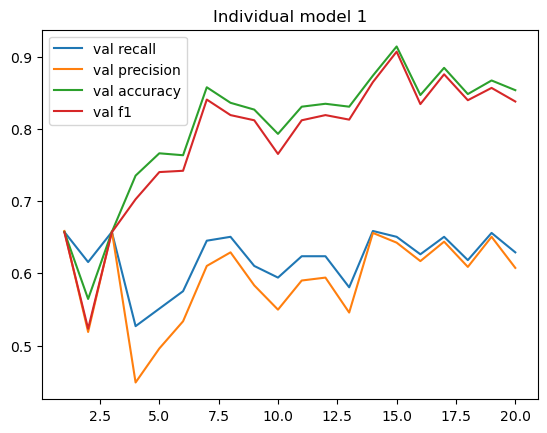

In [157]:
plt.plot(np.arange(1,21), [x[0] for x in hist[0][-2]], label="val recall")
plt.plot(np.arange(1,21), [x[1] for x in hist[0][-2]], label="val precision")
plt.plot(np.arange(1,21), [x[2] for x in hist[0][-2]], label="val accuracy")
plt.plot(np.arange(1,21), [x[3] for x in hist[0][-2]], label="val f1")
plt.legend()
plt.title("Individual model 1")

Text(0.5, 1.0, 'Individual model 2')

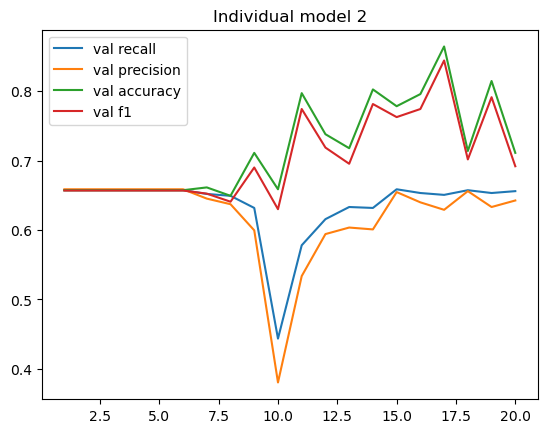

In [158]:
plt.plot(np.arange(1,21), [x[0] for x in hist[1][-2]], label="val recall")
plt.plot(np.arange(1,21), [x[1] for x in hist[1][-2]], label="val precision")
plt.plot(np.arange(1,21), [x[2] for x in hist[1][-2]], label="val accuracy")
plt.plot(np.arange(1,21), [x[3] for x in hist[1][-2]], label="val f1")
plt.legend()
plt.title("Individual model 2")

Text(0.5, 1.0, 'Individual model 3')

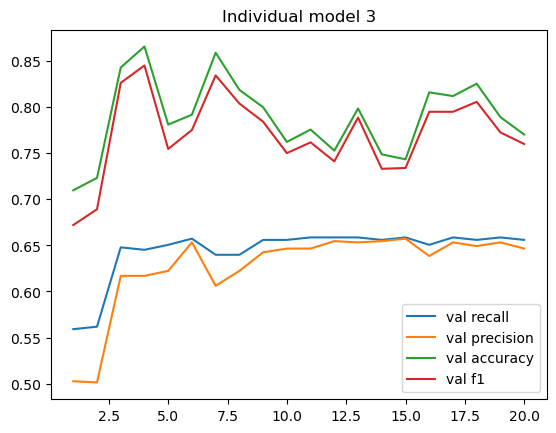

In [159]:
plt.plot(np.arange(1,21), [x[0] for x in hist[2][-2]], label="val recall")
plt.plot(np.arange(1,21), [x[1] for x in hist[2][-2]], label="val precision")
plt.plot(np.arange(1,21), [x[2] for x in hist[2][-2]], label="val accuracy")
plt.plot(np.arange(1,21), [x[3] for x in hist[2][-2]], label="val f1")
plt.legend()
plt.title("Individual model 3")

### Extended augmentation, attempt to balance classes

In [79]:
from torch.utils.data import DataLoader, Dataset
class imagesXNN_train(Dataset):
  def __init__(self, paths):
    self.fpaths = paths

  def __len__(self): return len(self.fpaths)

  def __getitem__(self, ix):
    f = self.fpaths[ix]
    res = torch.tensor(int("malignant" in f)).type(torch.LongTensor)
    im = cv2.imread(f)[:,:,::-1]
    
    if res.item()==0:
        r = random.random()
        if r<0.33:
            im = torch.tensor(im/255).permute(2,0,1).float()
            im = transforms.functional.rotate(angle=90, img=im)
            return transforms.Compose([ transforms.CenterCrop((440, 440)), 
                               transforms.RandomHorizontalFlip(), 
                               transforms.RandomVerticalFlip()])(im), res
        elif r<0.67:
            im = torch.tensor(im/255).permute(2,0,1).float()
            im = transforms.functional.rotate(angle=90, img=im)
            return transforms.Compose([transforms.CenterCrop((440, 440)), 
                               transforms.RandomHorizontalFlip(), 
                               transforms.RandomVerticalFlip()])(im), res
        else:
            return transforms.Compose([transforms.CenterCrop((440, 440)), 
                               transforms.RandomHorizontalFlip(), 
                               transforms.RandomVerticalFlip()])(torch.tensor(im/255).permute(2,0,1).float()), res
    else:
        return transforms.Compose([transforms.CenterCrop((440, 440)), 
                               transforms.RandomHorizontalFlip(), 
                               transforms.RandomVerticalFlip()])(torch.tensor(im/255).permute(2,0,1).float()), res


class imagesXNN_test(Dataset):
  def __init__(self, paths):
    self.fpaths = paths

  def __len__(self): return len(self.fpaths)

  def __getitem__(self, ix):
    f = self.fpaths[ix]
    res = torch.tensor(int("malignant" in f)).type(torch.LongTensor)
    im = cv2.imread(f)[:,:,::-1]
    return transforms.Compose([transforms.CenterCrop((440, 440))])(torch.tensor(im/255).permute(2,0,1).float()), res

In [80]:
train_full = df.loc[(df.fold==FOLD) & (df.mag==40) & (df.grp=="train")]["filename"].values
fold1 = df.loc[(df.fold==FOLD) & (df.mag==40) & (df.grp=="train")]["filename"].sample(frac=0.78).values
fold2 = df.loc[(df.fold==FOLD) & (df.mag==40) & (df.grp=="train")]["filename"].sample(frac=0.78).values
train_full = df.loc[(df.fold==FOLD) & (df.mag==40) & (df.grp=="train")]["filename"].values

In [81]:
def train_epoch(model, loader, criterion, scheduler,optim, local_metric_fn: Iterable):
    local_metric = [0] * len(local_metric_fn)
    local_loss = 0

    model.train()
    for step, (images, labels) in tqdm(enumerate(loader), total=995):
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        outputs = model(images)
        local_loss = criterion(outputs, labels)
        local_loss.backward()
        optim.step()
        optim.zero_grad()
        local_loss += local_loss.item()
        for i, metric in enumerate(local_metric_fn):
            local_metric[i] += metric(outputs.cpu().detach().numpy().argmax(axis=1), labels.cpu().numpy())
    scheduler.step()

    return local_loss/(step + 1), [metric/(step + 1) for metric in local_metric]

In [82]:
def valid_epoch(model, loader, criterion, local_metric_fn: Iterable):
    local_metric = [0] * len(local_metric_fn)
    local_loss = 0

    model.eval()
    for step, (images, labels) in enumerate(loader):
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        with torch.no_grad():
            outputs = model(images)
            local_loss = criterion(outputs, labels)
            local_loss += local_loss.item()
            for i, metric in enumerate(local_metric_fn):
                local_metric[i] += metric(outputs.cpu().detach().numpy().argmax(axis=1), labels.cpu().numpy())
    return local_loss/(step + 1), [metric/(step + 1) for metric in local_metric]

In [83]:

def train(model, num_epochs, train_dl, valid_dl, loss_fn, scheduler,  optimizer,local_metric_fn, i=0, tolerance = 0.5):
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs

    for epoch in range(num_epochs):

        loss_tr_ep, metrics_tr_ep = train_epoch(model, train_dl, loss_fn, scheduler, optimizer, local_metric_fn)

        loss_hist_train[epoch] = loss_tr_ep
        accuracy_hist_train[epoch] = metrics_tr_ep
        
        loss_ep, metrics_ep = valid_epoch(model, valid_dl, loss_fn, local_metric_fn)
        
        loss_hist_valid[epoch] = loss_ep
        accuracy_hist_valid[epoch] = metrics_ep
        if epoch == 0:
            bestAccVal = accuracy_hist_valid[epoch][2]
        else:
            if accuracy_hist_valid[epoch][2] > max(bestAccVal, tolerance):
                bestAccVal = accuracy_hist_valid[epoch][2]
                torch.save(model.state_dict(), f'bestmodel{i}.pt')

        print(f'Epoch {epoch+1} f1: {accuracy_hist_train[epoch][3]:{1}.{5}} val_f1: {accuracy_hist_valid[epoch][3]:{1}.{5}}')
        print(f'         acc: {accuracy_hist_train[epoch][2]:{1}.{5}} val_acc: {accuracy_hist_valid[epoch][2]:{1}.{5}}')
        print(f'         loss: {loss_tr_ep:{1}.{5}} val_loss: {loss_ep:{1}.{5}}\n')
    if os.path.exists(f'bestmodel{i}.pt'):
        model.load_state_dict(torch.load(f'bestmodel{i}.pt'))
    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid, bestAccVal

In [84]:
class MyEnsemble(nn.Module):
    def __init__(self, models):
        super(MyEnsemble, self).__init__()
        self.models = models

    def forward(self, x):

        pred = torch.Tensor([models["model"](x).cpu().numpy() for models in self.models])
        return pred
        

In [85]:
import pandas as pd

df = pd.read_csv("Folds.csv")

In [86]:
fold1 = df.loc[(df.fold==FOLD) & (df.mag==40) & (df.grp=="train")]["filename"].sample(frac=0.78).values
fold2 = df.loc[(df.fold==FOLD) & (df.mag==40) & (df.grp=="train")]["filename"].sample(frac=0.78).values
train_full = list(df.loc[(df.fold==FOLD) & (df.mag==40) & (df.grp=="train")]["filename"].values)

In [87]:
train_full[0].split("/")[3]

'benign'

In [88]:
for i in range(len(train_full)):
    if train_full[i].split("/")[3]=="benign":
        train_full.append(train_full[i])
        train_full.append(train_full[i])



In [89]:
len(train_full)

1990

In [90]:
test_40 = imagesXNN_test(df.loc[(df.fold==FOLD) & (df.mag==40) & (df.grp=="test")]["filename"].values)
test_dl = DataLoader(test_40, batch_size=4, shuffle=False, drop_last=True, num_workers = 0)

trn_ds = imagesXNN_train(train_full)
trn_dl = DataLoader(trn_ds, batch_size=4, shuffle=True, drop_last = True, num_workers = 0)

In [91]:
from tqdm import tqdm

In [92]:
model = torchvision.models.efficientnet_v2_l(weights=torchvision.models.EfficientNet_V2_L_Weights.DEFAULT)
model.classifier = nn.Sequential(nn.Linear(1280, 960), nn.ReLU(), nn.Dropout(0.2), 
                                 nn.Linear(960, 540), nn.ReLU(), nn.Dropout(0.2),
                                 nn.Linear(540, 320), nn.ReLU(), nn.Dropout(0.2),
                                 nn.Linear(320, 100), nn.ReLU(), nn.Dropout(0.2), 
                                 nn.Linear(100, 2), nn.Softmax(dim=1))

loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr= 2e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.6)
model.to(DEVICE)
local_metric_fn = [recall_score, precision_score, accuracy_score, f1_score]

train(model,20,trn_dl,test_dl,loss,scheduler,optimizer,local_metric_fn,i=100)

100%|██████████| 995/995 [04:24<00:00,  3.76it/s]


Epoch 1 f1: 0.45494 val_f1: 0.43817
         acc: 0.62161 val_acc: 0.68414
         loss: 0.0010097 val_loss: 0.0070549



100%|██████████| 995/995 [04:25<00:00,  3.75it/s]


Epoch 2 f1: 0.5129 val_f1: 0.14158
         acc: 0.66784 val_acc: 0.28763
         loss: 0.0013373 val_loss: 0.005353



100%|██████████| 995/995 [04:26<00:00,  3.73it/s]


Epoch 3 f1: 0.49715 val_f1: 0.44624
         acc: 0.6196 val_acc: 0.67473
         loss: 0.0014253 val_loss: 0.0042409



100%|██████████| 995/995 [04:26<00:00,  3.74it/s]


Epoch 4 f1: 0.39397 val_f1: 0.078853
         acc: 0.58392 val_acc: 0.36694
         loss: 0.0012085 val_loss: 0.0043289



100%|██████████| 995/995 [04:26<00:00,  3.73it/s]


Epoch 5 f1: 0.45729 val_f1: 0.52509
         acc: 0.64824 val_acc: 0.7621
         loss: 0.0017831 val_loss: 0.0060373



100%|██████████| 995/995 [04:26<00:00,  3.73it/s]


Epoch 6 f1: 0.53367 val_f1: 0.4776
         acc: 0.69447 val_acc: 0.67876
         loss: 0.00065531 val_loss: 0.0070206



100%|██████████| 995/995 [04:27<00:00,  3.72it/s]


Epoch 7 f1: 0.55343 val_f1: 0.5914
         acc: 0.70704 val_acc: 0.77957
         loss: 0.00064184 val_loss: 0.0049312



100%|██████████| 995/995 [04:27<00:00,  3.72it/s]


Epoch 8 f1: 0.55678 val_f1: 0.60663
         acc: 0.71508 val_acc: 0.6922
         loss: 0.00086653 val_loss: 0.0020511



100%|██████████| 995/995 [04:28<00:00,  3.70it/s]


Epoch 9 f1: 0.58358 val_f1: 0.58333
         acc: 0.73015 val_acc: 0.7164
         loss: 0.0014456 val_loss: 0.0038624



100%|██████████| 995/995 [04:27<00:00,  3.72it/s]


Epoch 10 f1: 0.58827 val_f1: 0.60125
         acc: 0.72362 val_acc: 0.69355
         loss: 0.00062984 val_loss: 0.0045433



100%|██████████| 995/995 [04:27<00:00,  3.72it/s]


Epoch 11 f1: 0.58559 val_f1: 0.60394
         acc: 0.80151 val_acc: 0.73522
         loss: 0.00063339 val_loss: 0.0018411



100%|██████████| 995/995 [05:46<00:00,  2.87it/s]


Epoch 12 f1: 0.57286 val_f1: 0.55466
         acc: 0.82211 val_acc: 0.73656
         loss: 0.00064795 val_loss: 0.0039706



100%|██████████| 995/995 [06:04<00:00,  2.73it/s]


Epoch 13 f1: 0.58995 val_f1: 0.57348
         acc: 0.86784 val_acc: 0.75672
         loss: 0.000637 val_loss: 0.0030075



100%|██████████| 995/995 [04:39<00:00,  3.56it/s]


Epoch 14 f1: 0.58995 val_f1: 0.53584
         acc: 0.85879 val_acc: 0.75538
         loss: 0.00075857 val_loss: 0.0054798



100%|██████████| 995/995 [04:27<00:00,  3.71it/s]


Epoch 15 f1: 0.59799 val_f1: 0.60573
         acc: 0.88241 val_acc: 0.74866
         loss: 0.00063084 val_loss: 0.0021393



100%|██████████| 995/995 [04:27<00:00,  3.72it/s]


Epoch 16 f1: 0.60335 val_f1: 0.6129
         acc: 0.88693 val_acc: 0.74597
         loss: 0.0019381 val_loss: 0.0043573



100%|██████████| 995/995 [04:27<00:00,  3.72it/s]


Epoch 17 f1: 0.61407 val_f1: 0.5233
         acc: 0.89749 val_acc: 0.76882
         loss: 0.00063054 val_loss: 0.0063467



100%|██████████| 995/995 [04:28<00:00,  3.71it/s]


Epoch 18 f1: 0.6258 val_f1: 0.6147
         acc: 0.90302 val_acc: 0.75538
         loss: 0.00067928 val_loss: 0.0038034



100%|██████████| 995/995 [04:28<00:00,  3.71it/s]


Epoch 19 f1: 0.6258 val_f1: 0.6147
         acc: 0.90955 val_acc: 0.76075
         loss: 0.00063081 val_loss: 0.0039141



100%|██████████| 995/995 [04:27<00:00,  3.72it/s]


Epoch 20 f1: 0.62546 val_f1: 0.6138
         acc: 0.89347 val_acc: 0.72177
         loss: 0.00063005 val_loss: 0.0029594



([tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(0.0014, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(0.0018, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(0.0007, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(0.0006, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(0.0014, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(0.0006, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(0.0006, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(0.0006, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(0.0006, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(0.0006, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(0.0019, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(0.0006, device='cuda:0', grad_fn=<DivBackward0>

### Frozen layers

In [94]:
model1 = torchvision.models.efficientnet_v2_l(weights=torchvision.models.EfficientNet_V2_L_Weights.DEFAULT)
for param in model1.features[7].parameters():
    param.requires_grad = False
model1.classifier = nn.Sequential(nn.Linear(1280, 512), nn.ReLU(), nn.Dropout(0.2),nn.Linear(512, 2))

loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model1.parameters(), lr= 2e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.6)
model1.to(DEVICE)
local_metric_fn = [recall_score, precision_score, accuracy_score, f1_score]

train(model1,4,trn_dl,test_dl,loss,scheduler,optimizer,local_metric_fn,i=100)

100%|██████████| 995/995 [04:15<00:00,  3.89it/s]


Epoch 1 f1: 0.52127 val_f1: 0.40502
         acc: 0.70151 val_acc: 0.65054
         loss: 0.00082393 val_loss: 0.028489



100%|██████████| 995/995 [04:15<00:00,  3.89it/s]


Epoch 2 f1: 0.57856 val_f1: 0.56183
         acc: 0.8196 val_acc: 0.65726
         loss: 0.00015438 val_loss: 0.0088318



100%|██████████| 995/995 [04:16<00:00,  3.88it/s]


Epoch 3 f1: 0.62647 val_f1: 0.65233
         acc: 0.9005 val_acc: 0.6828
         loss: 0.00057441 val_loss: 0.0028024



100%|██████████| 995/995 [04:15<00:00,  3.89it/s]


Epoch 4 f1: 0.64255 val_f1: 0.62366
         acc: 0.93116 val_acc: 0.77554
         loss: 0.0005061 val_loss: 0.0081029



([tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(0.0002, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(0.0006, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(0.0005, device='cuda:0', grad_fn=<DivBackward0>)],
 [tensor(0.0285, device='cuda:0'),
  tensor(0.0088, device='cuda:0'),
  tensor(0.0028, device='cuda:0'),
  tensor(0.0081, device='cuda:0')],
 [[0.5608040201005026,
   0.5065326633165829,
   0.7015075376884422,
   0.5212730318257964],
  [0.6025125628140704,
   0.5753768844221105,
   0.8195979899497488,
   0.5785594639866001],
  [0.6346733668341709,
   0.6331658291457286,
   0.9005025125628141,
   0.6264656616415408],
  [0.6477386934673367,
   0.6472361809045226,
   0.9311557788944723,
   0.6425460636515911]],
 [[0.4543010752688172,
   0.3803763440860215,
   0.6505376344086021,
   0.4050179211469533],
  [0.5860215053763441,
   0.5497311827956989,
   0.657258064516129,
   0.561827956989247],
  [0.6586021505376344,
   0.6491935483870968,
   0.68279569892473